# **Data-Science Fundamentals Final Project: predicting flights using ML algorithms**

## Stage No. 1: collecting the data:
- for this stage we will use a web scraper-collector that will collect flights data from two websites: Kiwi and Kayak.
- this collector is built with async-runtime functions, random user-actions generator, session saver, cookies saver, dynamic viewport and even DHCP-ip-refresher function (since were not using proxy), all of these methods are used for collecting without getting cought by these websities bot-identifier machenisms...
- this collector will run every combination of ttt (time to travel) from 1-30, los (lenght of stay) from 1-5 within a 3 different snapshot days for every combination of rome,london and paris routes

In [54]:
# %pip install -e scraping
# %playwright install

In [55]:
# from scraping.flights_scraping import get_data


# get_data()


After we have collected the data: were doing the usual imports:

In [56]:
# Basic imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import os
import re
import time
import random
import datetime
import warnings
from tqdm import tqdm

##################### Preprocessing imports 
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from category_encoders import TargetEncoder
from sklearn.impute import KNNImputer

##################### Models
from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostClassifier, CatBoostRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

#### Model selection 
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingRegressor
from sklearn.inspection import permutation_importance
from sklearn.base import clone
from sklearn.metrics import cohen_kappa_score
from scipy.optimize import minimize
from IPython.display import clear_output
from concurrent.futures import ThreadPoolExecutor

##################### optuna library import
# !pip install shap
import optuna
import shap
import matplotlib.cm as cm
from collections import defaultdict
random_state = 42
n_splits = 5

## Stage 2: Exploring the data

In [57]:
data = pd.read_csv('Flights.csv')

In [58]:
# Table for first look
def summary(train):
    sum = pd.DataFrame(train.dtypes, columns=['dtypes'])
    sum['missing#'] = train.isna().sum()
    sum['missing%'] = (train.isna().sum())/len(train)
    sum['uniques'] = train.nunique().values
    sum['count'] = train.count().values
    return sum

display(summary(data).style.background_gradient(cmap='Blues'))
data.head(1)

,dtypes,missing#,missing%,uniques,count
departure_hour,object,33498,0.067904,415,459813
departure_airport,object,38721,0.078492,13,454590
flight_length,object,33498,0.067904,170,459813
landing_hour,object,37733,0.076489,431,455578
landing_airport,object,38000,0.077031,13,455311
to_dest_company,object,42175,0.085494,35,451136
return_departure_hour,object,33498,0.067904,413,459813
return_departure_airport,object,38693,0.078435,211,454618
return_flight_length,object,33498,0.067904,167,459813
return_landing_hour,object,38693,0.078435,442,454618


,departure_hour,departure_airport,flight_length,landing_hour,landing_airport,to_dest_company,return_departure_hour,return_departure_airport,return_flight_length,return_landing_hour,return_landing_airport,return_company,price,layover,ttt,los,snapshot_date,origin_city,destination_city,departure_date,return_date,website,layover_time,return_layover_time
0,6:00a,CIA,2h 45m,7:45a,STN,Ryanair,6:10p,STN,2h 25m,9:35p,CIA,Ryanair,$168,False,2,1,2025-02-28,ROME,LONDON,2025-03-02,2025-03-03,Kayak,0m,0m


In [59]:
data.head()

,departure_hour,departure_airport,flight_length,landing_hour,landing_airport,to_dest_company,return_departure_hour,return_departure_airport,return_flight_length,return_landing_hour,return_landing_airport,return_company,price,layover,ttt,los,snapshot_date,origin_city,destination_city,departure_date,return_date,website,layover_time,return_layover_time
0,6:00a,CIA,2h 45m,7:45a,STN,Ryanair,6:10p,STN,2h 25m,9:35p,CIA,Ryanair,$168,False,2,1,2025-02-28,ROME,LONDON,2025-03-02,2025-03-03,Kayak,0m,0m
1,6:35a,FCO,2h 45m,8:20a,LGW,Wizz Air,9:10a,STN,2h 30m,12:40p,FCO,Jet2,$157,False,2,1,2025-02-28,ROME,LONDON,2025-03-02,2025-03-03,Kayak,0m,0m
2,6:35a,FCO,2h 45m,8:20a,LGW,Wizz Air,6:10p,STN,2h 25m,9:35p,CIA,Ryanair,$166,False,2,1,2025-02-28,ROME,LONDON,2025-03-02,2025-03-03,Kayak,0m,0m
3,6:00a,CIA,2h 45m,7:45a,STN,Ryanair,6:10p,STN,2h 25m,9:35p,CIA,Ryanair,$168,False,2,1,2025-02-28,ROME,LONDON,2025-03-02,2025-03-03,Kayak,0m,0m
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,2,1,2025-02-28,ROME,LONDON,2025-03-02,2025-03-03,Kayak,0m,0m


Remove duplicates and nulls

In [60]:
data = data.drop_duplicates()
data = data.dropna()

we will add a function that will convert the time strings to int (in minutes)

In [61]:

import re
def time_to_minutes(time_str: str)-> int:
    if pd.isna(time_str):
        return 0

    # Extract hours and minutes using regex
    hours = 0
    minutes = 0
    
    h_match = re.search(r'(\d+)h', time_str)
    m_match = re.search(r'(\d+)m', time_str)

    if h_match:
        hours = int(h_match.group(1))
    if m_match:
        minutes = int(m_match.group(1))

    return hours * 60 + minutes

In [62]:
data['flight_length'] = data['flight_length'].apply(time_to_minutes)
data['return_flight_length'] = data['return_flight_length'].apply(time_to_minutes)
data['layover_time'] = data['layover_time'].apply(time_to_minutes)
data['return_layover_time'] = data['return_layover_time'].apply(time_to_minutes)

lets convert the hours to int format

In [63]:
from datetime import datetime
def hour_to_numeric(hour_str):
    hour_str = hour_str.strip()  

    
    match = re.search(r"\+(\d+)", hour_str)
    extra_days = int(match.group(1)) if match else 0
    hour_str = re.sub(r"\+\d+", "", hour_str)

    
    if 'a' in hour_str or 'p' in hour_str:
        hour_str = hour_str.replace('a', 'AM').replace('p', 'PM')
        time_obj = datetime.strptime(hour_str, "%I:%M%p")
    else:
        time_obj = datetime.strptime(hour_str, "%H:%M")

    hour_float = time_obj.hour + time_obj.minute / 60

    hour_float += extra_days * 24

    return hour_float


data['departure_hour'] = data['departure_hour'].apply(hour_to_numeric)
data['landing_hour'] = data['landing_hour'].apply(hour_to_numeric)
data['return_departure_hour'] = data['return_departure_hour'].apply(hour_to_numeric)
data['return_landing_hour'] = data['return_landing_hour'].apply(hour_to_numeric)


the price is still an object! we need to convert it to numerical... (with scraping knowlage we know that kiwi gives the price in nis and kayak in $)

In [64]:
%pip install currencyconverter

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [65]:
from currency_converter import CurrencyConverter

c = CurrencyConverter()

data['price'] = data['price'].apply(
    lambda x: (
        c.convert(float(x.replace('₪ ', '').replace(',', '')), 'ILS', 'USD') if '₪ ' in x
        else float(x.replace('$', '').replace(',', '')) if '$' in x 
        else None 
    )
)


we know that dates are tied to day of week, lets create new feature based on the departure date!

In [66]:

data['departure_date'] = pd.to_datetime(data['departure_date'])
    
data['day_of_week'] = data['departure_date'].dt.day_name()

lets create new feature based on the origin_city and destination_city

In [67]:
data['route'] = data['origin_city'] + ' → ' + data['destination_city']

In [68]:
pd.set_option('display.max_columns', None)
data.head()

,departure_hour,departure_airport,flight_length,landing_hour,landing_airport,to_dest_company,return_departure_hour,return_departure_airport,return_flight_length,return_landing_hour,return_landing_airport,return_company,price,layover,ttt,los,snapshot_date,origin_city,destination_city,departure_date,return_date,website,layover_time,return_layover_time,day_of_week,route
0,6.000000,CIA,165,7.750000,STN,Ryanair,18.166667,STN,145,21.583333,CIA,Ryanair,168.0,False,2,1,2025-02-28,ROME,LONDON,2025-03-02,2025-03-03,Kayak,0,0,Sunday,ROME → LONDON
1,6.583333,FCO,165,8.333333,LGW,Wizz Air,9.166667,STN,150,12.666667,FCO,Jet2,157.0,False,2,1,2025-02-28,ROME,LONDON,2025-03-02,2025-03-03,Kayak,0,0,Sunday,ROME → LONDON
2,6.583333,FCO,165,8.333333,LGW,Wizz Air,18.166667,STN,145,21.583333,CIA,Ryanair,166.0,False,2,1,2025-02-28,ROME,LONDON,2025-03-02,2025-03-03,Kayak,0,0,Sunday,ROME → LONDON
5,6.583333,FCO,165,8.333333,LGW,Wizz Air,21.000000,LGW,150,24.500000,FCO,Wizz Air,165.0,False,2,1,2025-02-28,ROME,LONDON,2025-03-02,2025-03-03,Kayak,0,0,Sunday,ROME → LONDON
6,6.583333,FCO,165,8.333333,LGW,Wizz Air,6.250000,STN,145,9.666667,CIA,Ryanair,168.0,False,2,1,2025-02-28,ROME,LONDON,2025-03-02,2025-03-03,Kayak,0,0,Sunday,ROME → LONDON


fancy distribution graphs

c:\Users\Nadav\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


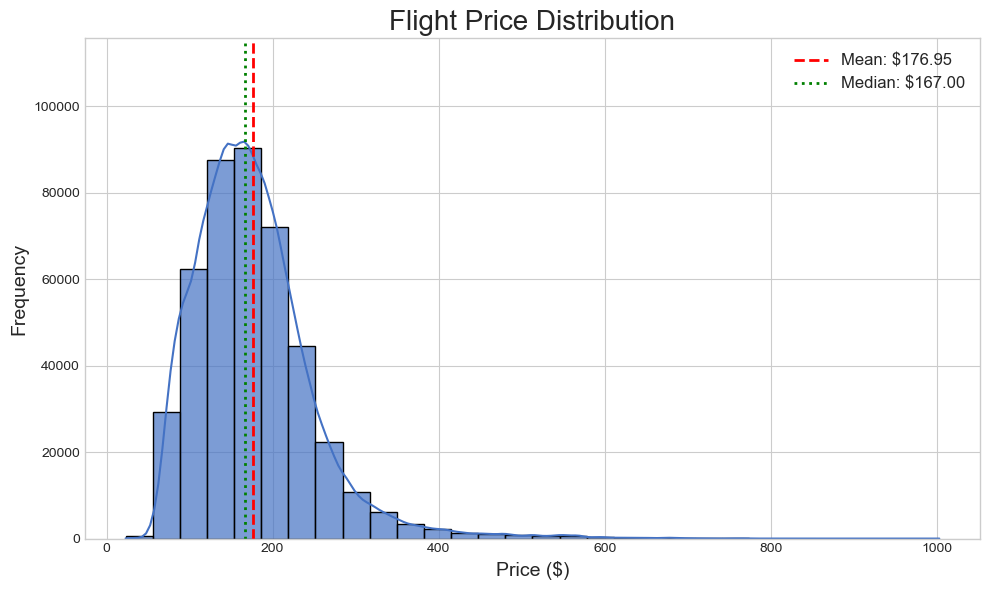

In [69]:
plt.style.use('seaborn-v0_8-whitegrid')

plt.figure(figsize=(10, 6))
plt.title('Flight Price Distribution', fontsize=20)

sns.histplot(data['price'], bins=30, kde=True, color='#4472C4', 
             edgecolor='black', alpha=0.7)

mean_price = data['price'].mean()
median_price = data['price'].median()
plt.axvline(mean_price, color='red', linestyle='--', linewidth=2, 
            label=f'Mean: ${mean_price:.2f}')
plt.axvline(median_price, color='green', linestyle=':', linewidth=2, 
            label=f'Median: ${median_price:.2f}')

plt.ylim(0, plt.ylim()[1] * 1.2)

plt.xlabel('Price ($)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

by company

In [70]:
from scipy.stats import skew, kurtosis
display(kurtosis(data['price']))
skew(data['price'])

6.22985229583405

1.7049776125112948

In [71]:
data_value_counts = data['to_dest_company'].value_counts()
data_value_counts = pd.DataFrame(data_value_counts).style.background_gradient("cool")
data_value_counts

,count
to_dest_company,
easyJet,121360
Vueling,97014
Ryanair,76422
Wizz Air,34636
ITA Airways,26677
British Airways,26492
Transavia France,18721
Air France,12428
Wizz Air Malta,10191


/// We can notice that there is some data that is either for example: "" 

In [85]:
company_mapping = {
    'Wizz Air Malta': 'Wizz Air',
    'Wizz Air UK': 'Wizz Air',
    'Ryanair UK': 'Ryanair',
    'Multiple airlines': 'Other',
    'Scandinavian Airlines': 'SAS',
    'KM Malta Airlines': 'Other',
    'Aeroitalia': 'Other',
    'FlixBus': 'Other',
    'BlaBlaBus': 'Other',
    'Union Ivkoni': 'Other',
    'Brussels Airlines': 'Other',
    'SWISS': 'Other',
    'Volotea': 'Other'
}

data['to_dest_company'] = data['to_dest_company'].replace(company_mapping)
data['return_company'] = data['return_company'].replace(company_mapping)

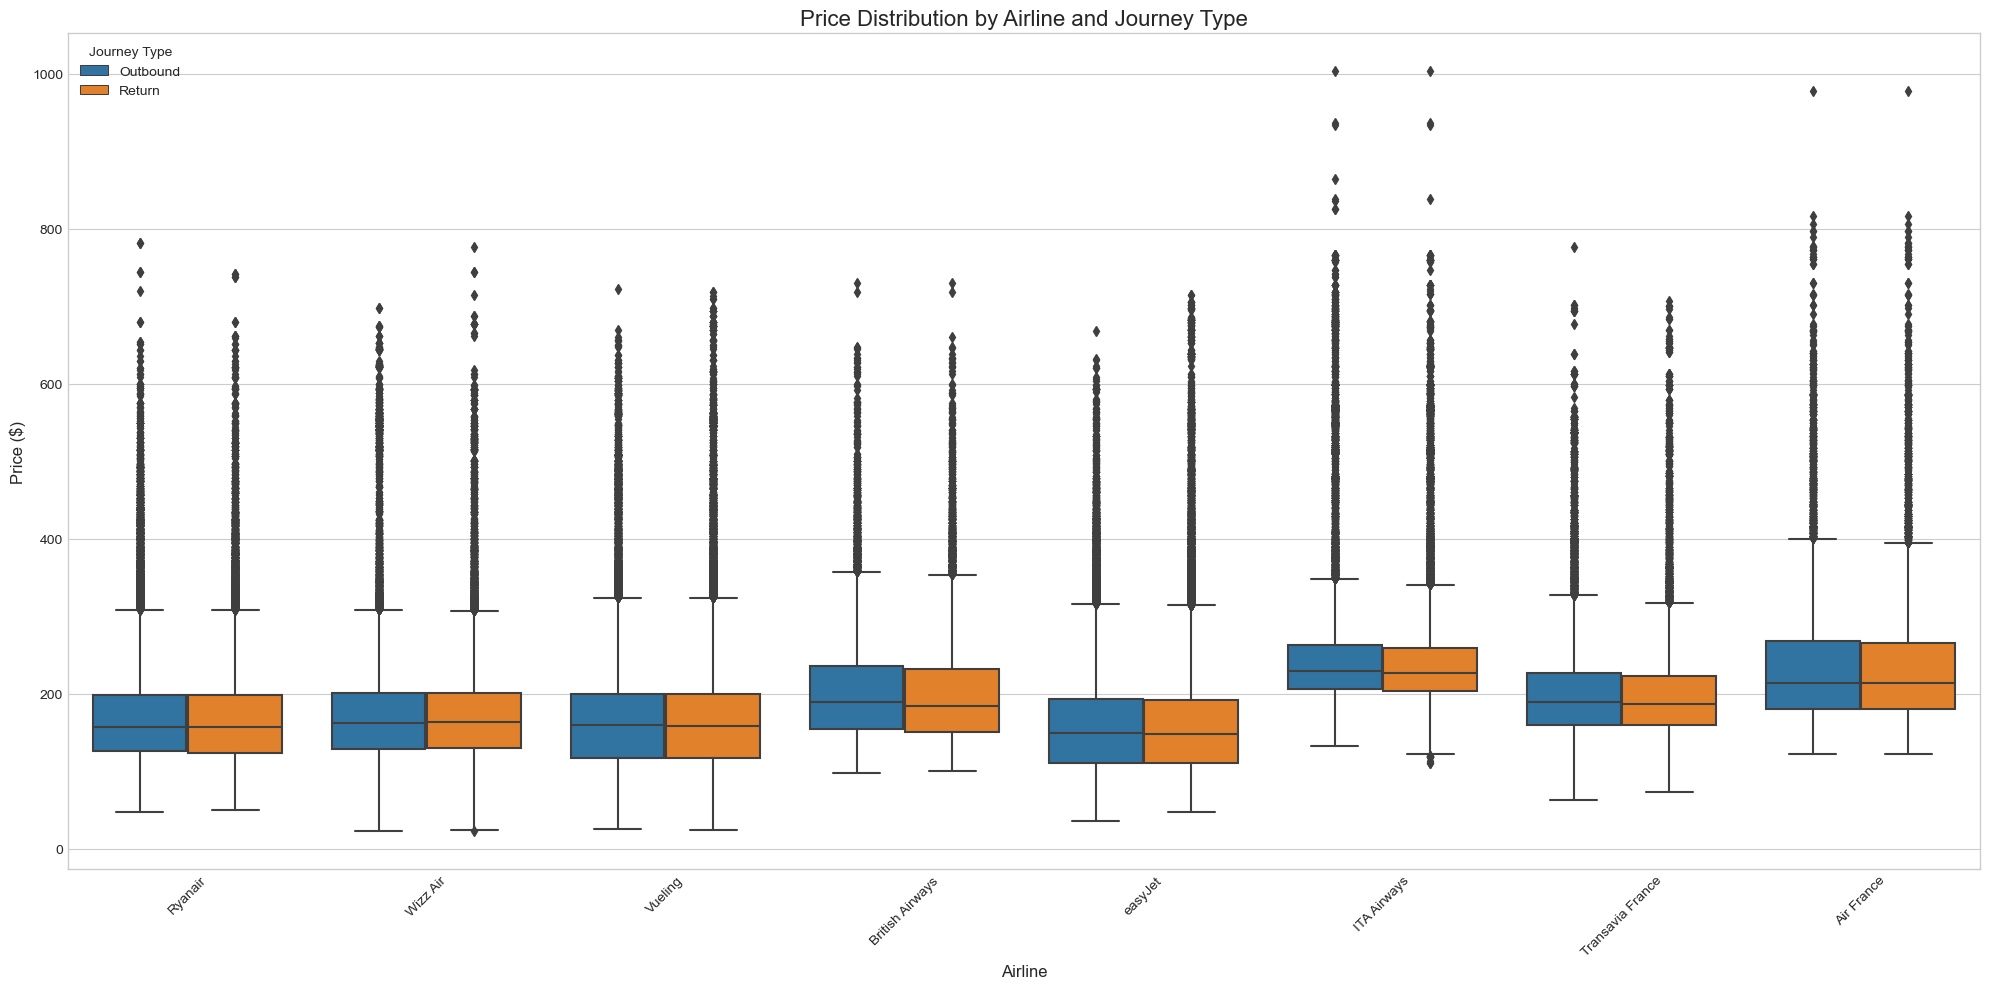

In [73]:
plt.figure(figsize=(20, 10))

# Prepare outbound data
outbound_data = data[['price', 'to_dest_company']].copy()
outbound_data['journey_type'] = 'Outbound'
outbound_data.rename(columns={'to_dest_company': 'company'}, inplace=True)

# Prepare return data
return_data = data[['price', 'return_company']].copy()
return_data['journey_type'] = 'Return'
return_data.rename(columns={'return_company': 'company'}, inplace=True)

# Combine both datasets
combined_data = pd.concat([outbound_data, return_data])

# Get the top 10 most frequent airlines
top_airlines = combined_data['company'].value_counts().nlargest(8).index.tolist()
combined_data_filtered = combined_data[combined_data['company'].isin(top_airlines)]

# Create the boxplot
sns.boxplot(x='company', y='price', hue='journey_type', data=combined_data_filtered)

# Set labels and title
plt.xlabel('Airline', fontsize=12)
plt.ylabel('Price ($)', fontsize=12)
plt.title('Price Distribution by Airline and Journey Type', fontsize=16)

# Rotate x-axis labels for readability
plt.xticks(rotation=45)

# Add legend
plt.legend(title='Journey Type')

# Show the plot
plt.tight_layout()
plt.show()

In [74]:
data.columns

Index(['departure_hour', 'departure_airport', 'flight_length', 'landing_hour',
       'landing_airport', 'to_dest_company', 'return_departure_hour',
       'return_departure_airport', 'return_flight_length',
       'return_landing_hour', 'return_landing_airport', 'return_company',
       'price', 'layover', 'ttt', 'los', 'snapshot_date', 'origin_city',
       'destination_city', 'departure_date', 'return_date', 'website',
       'layover_time', 'return_layover_time', 'day_of_week', 'route'],
      dtype='object')

In [75]:
def price_per_feature(column: str):
    plt.figure(figsize=(20, 10))
    top_routes = data[column].value_counts().index.tolist()
    cities_data = data[data[column].isin(top_routes)]

    sns.boxplot(x= column, y='price', data=cities_data, palette='Set1')
    plt.title(f'Price by {column}', fontsize=14)
    plt.xlabel(column, fontsize=12)
    plt.ylabel('Price ($)', fontsize=12)

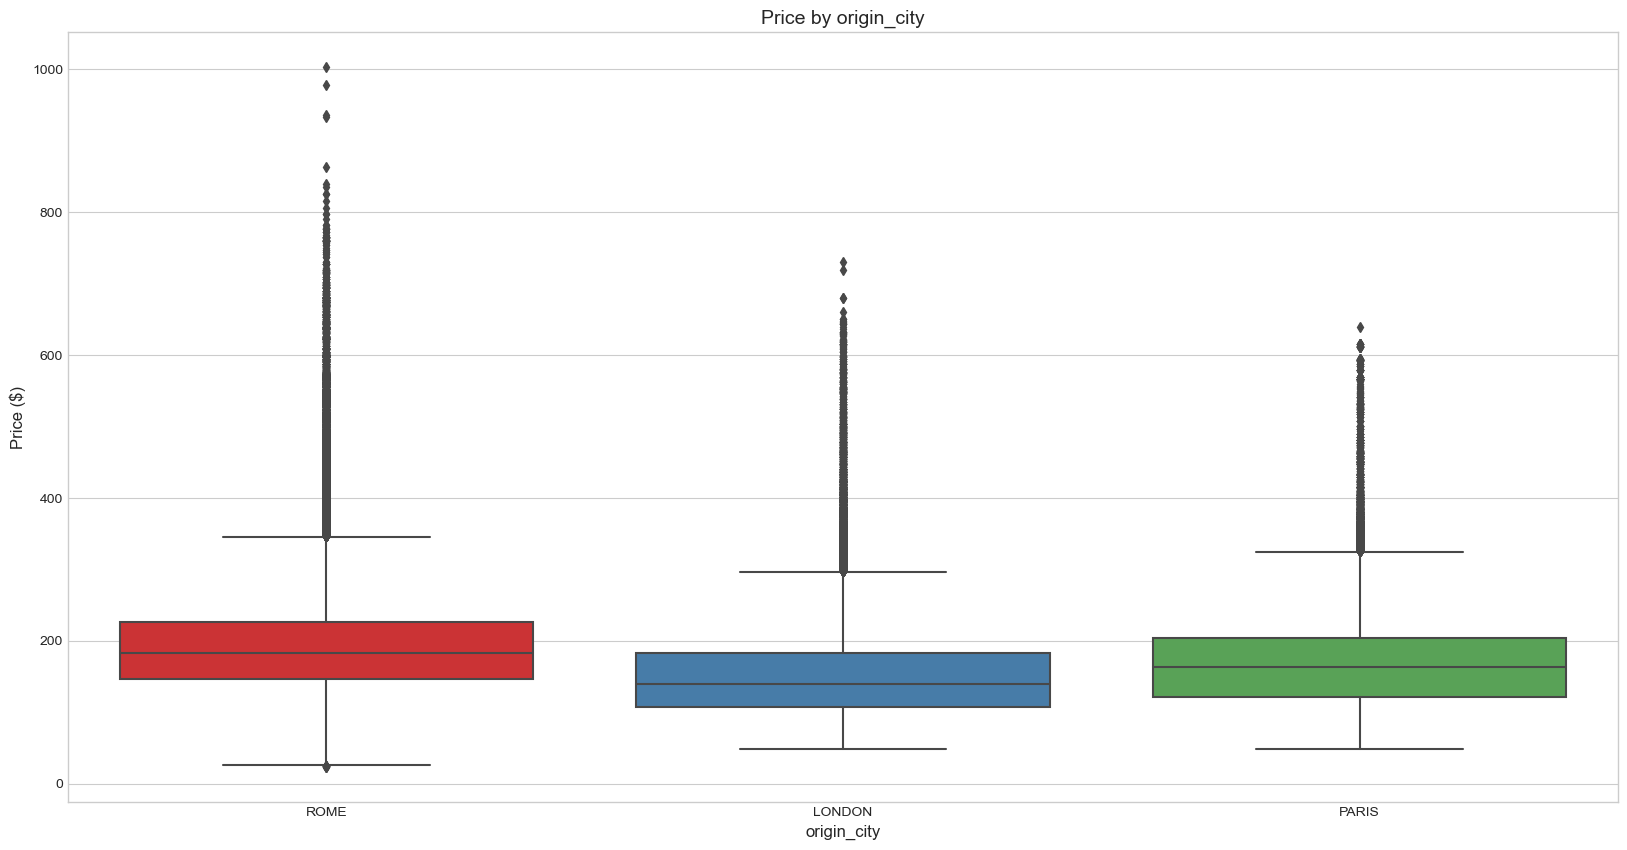

In [76]:
price_per_feature('origin_city')

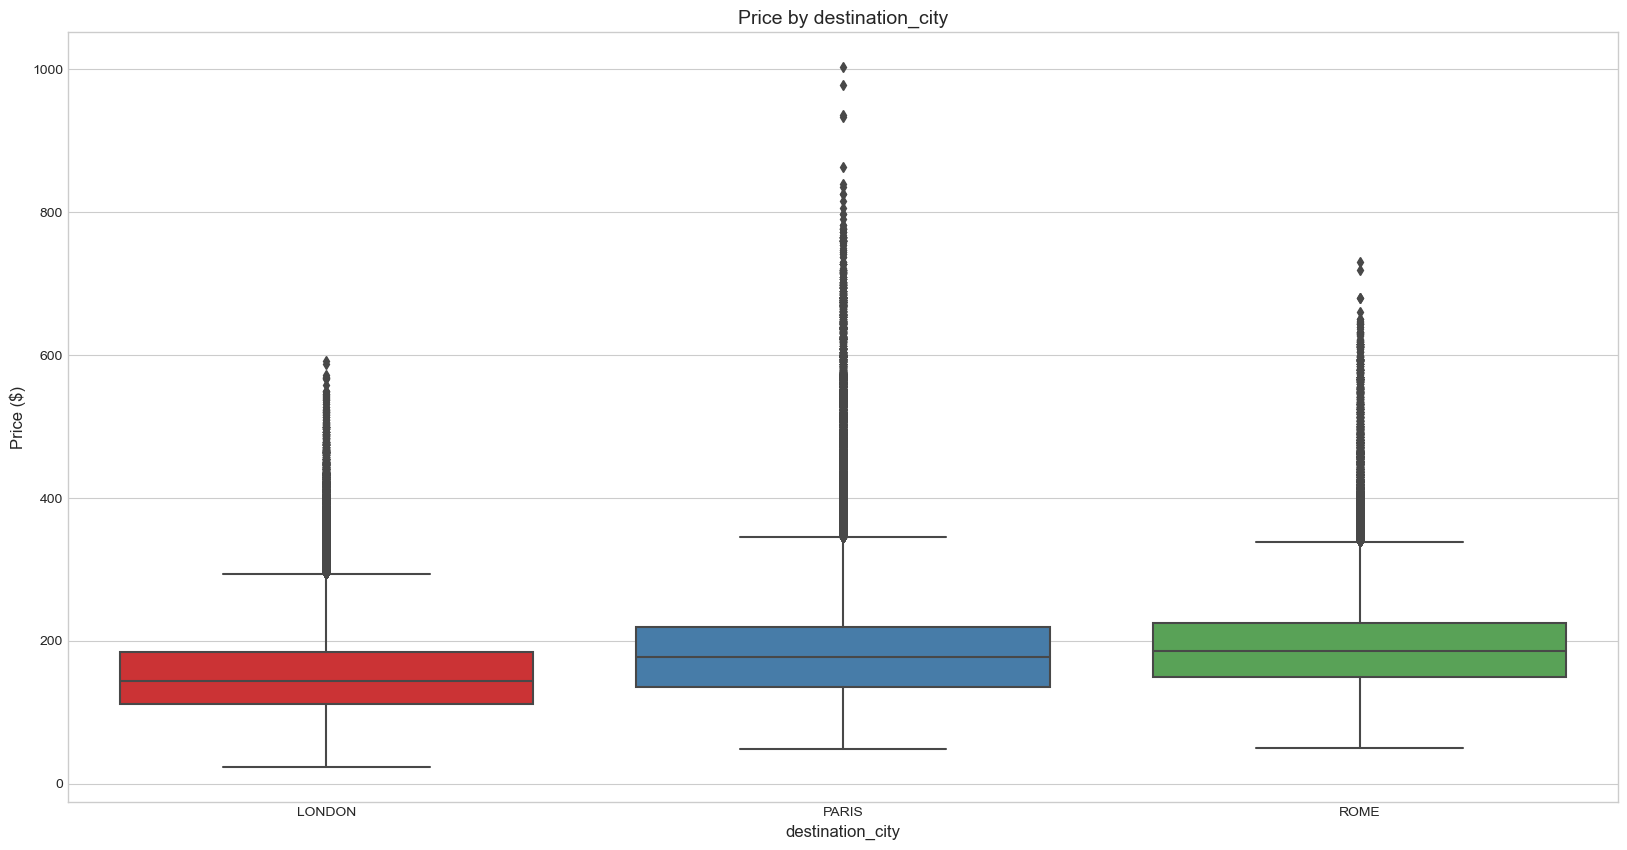

In [77]:
price_per_feature('destination_city')

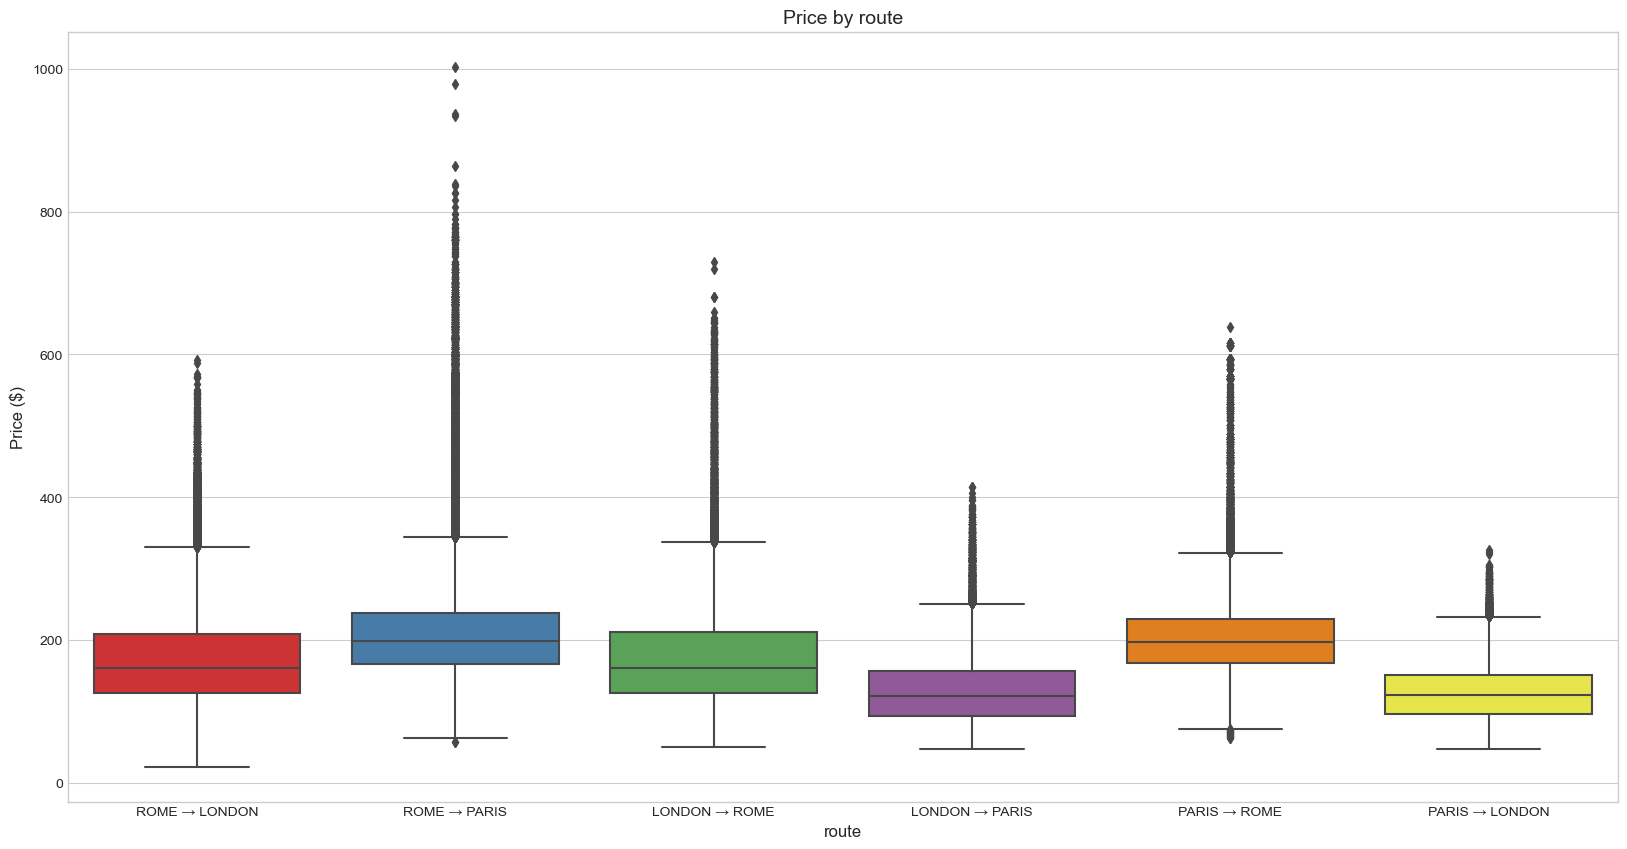

In [78]:
price_per_feature('route')

Insights
</br>
Rome is the most expensive distination to fly from and to 
We can infer that the reason for the higher prices in Rome come from the fact that it is the most toured  

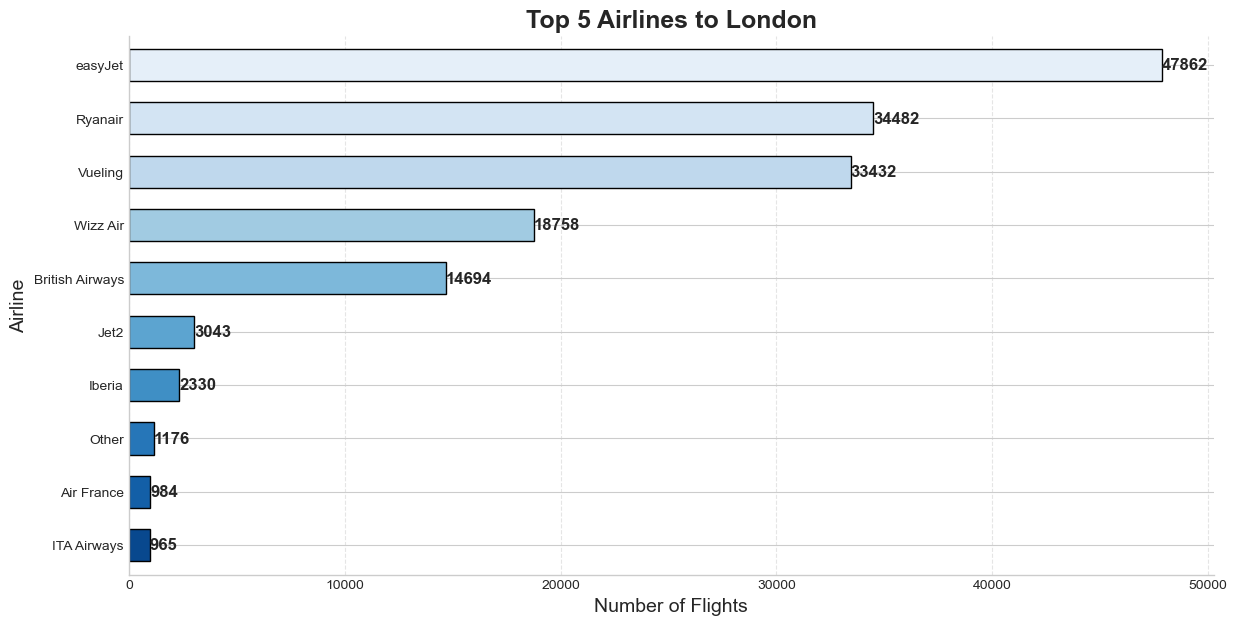

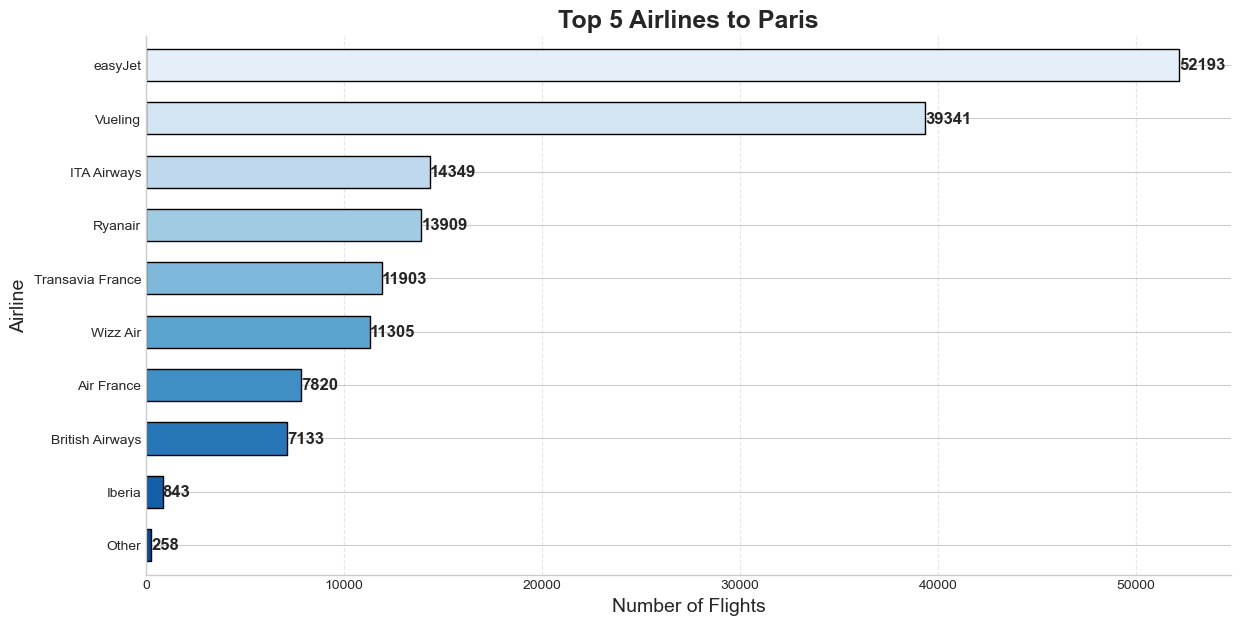

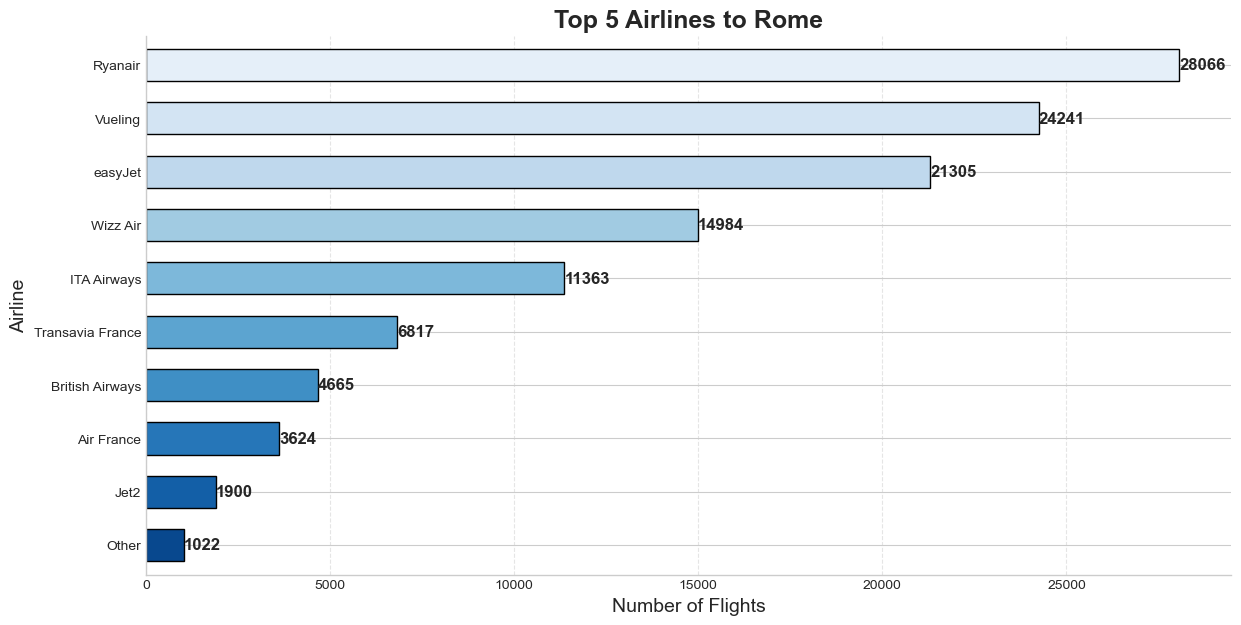

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style for better visualization
sns.set_style("whitegrid")

def flight_count(data):
    flight_counts = data.groupby(["destination_city", "to_dest_company"]).size().unstack().fillna(0)

    # Get the top 5 airlines with the most flights for each destination
    london_flights = flight_counts.loc["LONDON"].nlargest(10)
    paris_flights = flight_counts.loc["PARIS"].nlargest(10)
    rome_flights = flight_counts.loc["ROME"].nlargest(10)

    # Plot the results
    flights_counts(london_flights, "London")
    flights_counts(paris_flights, "Paris")
    flights_counts(rome_flights, "Rome")

def flights_counts(dest_flight_counts, dest):
    fig, ax = plt.subplots(figsize=(14, 7))

    # Plot sorted bar chart
    bars = dest_flight_counts.sort_values(ascending=True).plot(
        kind="barh", 
        ax=ax, 
        edgecolor="black", 
        width=0.6,  # Reduce bar spacing
        color=sns.color_palette("Blues_r", len(dest_flight_counts))
    )

    # Improve aesthetics
    ax.set_title(f"Top 10 Airlines to {dest}", fontsize=18, fontweight="bold")
    ax.set_xlabel("Number of Flights", fontsize=14)
    ax.set_ylabel("Airline", fontsize=14)
    ax.grid(axis="x", linestyle="--", alpha=0.5)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    
    # Add value labels
    for bar in bars.patches:
        ax.text(bar.get_width(), bar.get_y() + bar.get_height()/2, 
                f'{int(bar.get_width())}', 
                ha='left', va='center', fontsize=12, fontweight="bold")

    plt.show()

# Call the function
flight_count(data)


weekdays

c:\Users\Nadav\anaconda3\Lib\site-packages\seaborn\categorical.py:645: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  g_vals = grouped_vals.get_group(g)
c:\Users\Nadav\anaconda3\Lib\site-packages\seaborn\categorical.py:645: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  g_vals = grouped_vals.get_group(g)
c:\Users\Nadav\anaconda3\Lib\site-packages\seaborn\categorical.py:645: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  g_vals = grouped_vals.get_group(g)
c:\Users\Nadav\anaconda3\Lib\site-packages\seaborn\categorical.py:645: FutureWarning:

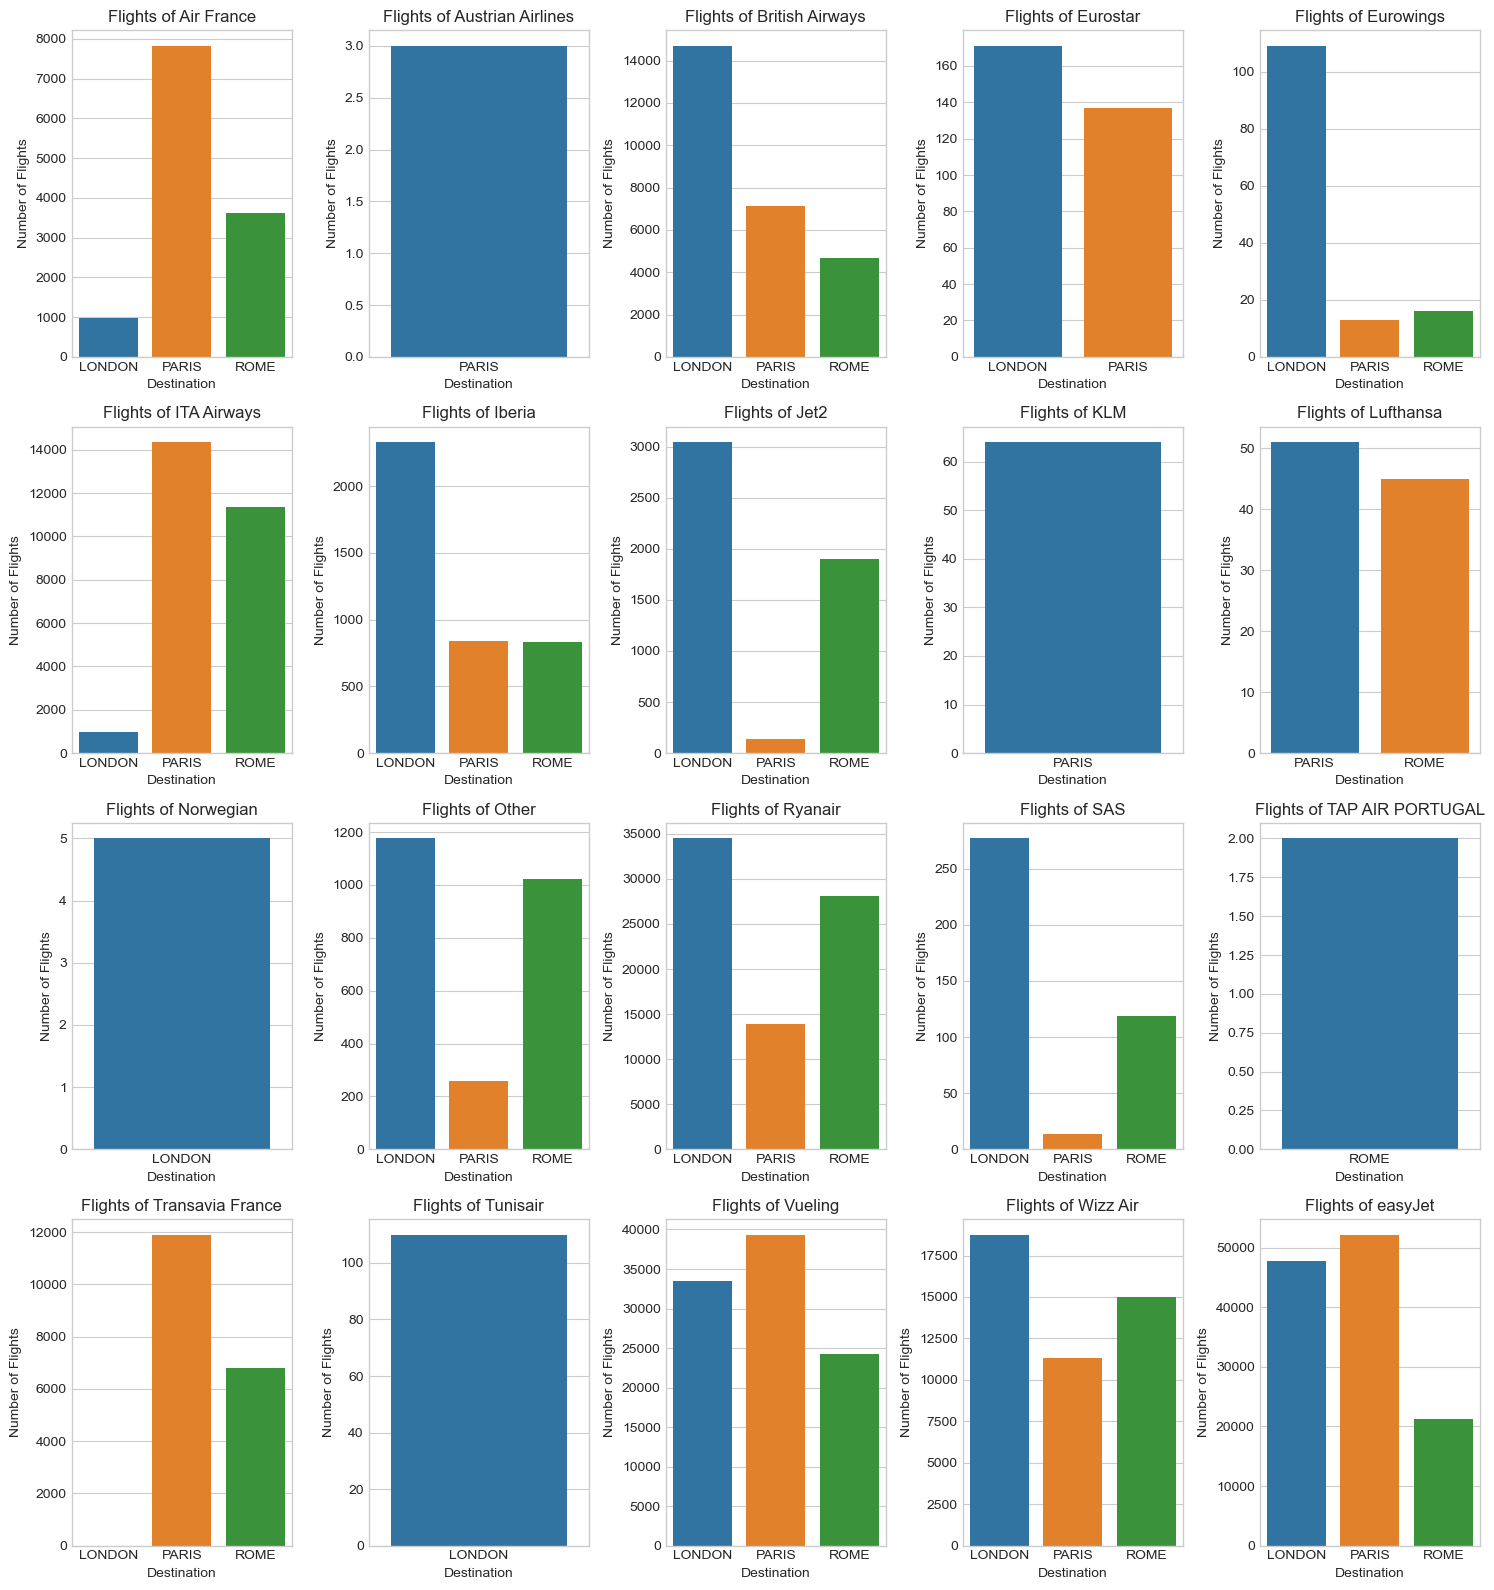

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_flight_counts(data, num_cols_per_row=5):
    # Group data by flight company and destination, then count flights
    flight_counts = data.groupby(['to_dest_company', 'destination_city']).size().reset_index(name='count')

    # Get unique airlines
    airlines = flight_counts['to_dest_company'].unique()
    num_airlines = len(airlines)
    num_rows = int(np.ceil(num_airlines / num_cols_per_row))

    # Create subplots
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols_per_row, figsize=(15, 4 * num_rows))
    axes = axes.flatten()

    # Plot barplot for each airline
    for i, airline in enumerate(airlines):
        subset = flight_counts[flight_counts['to_dest_company'] == airline]
        sns.barplot(x='destination_city', y='count', data=subset, ax=axes[i])
        axes[i].set_title(f'Flights of {airline}')
        axes[i].set_xlabel('Destination')
        axes[i].set_ylabel('Number of Flights')

    # Hide extra subplots
    for i in range(len(airlines), len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
plot_flight_counts(data)


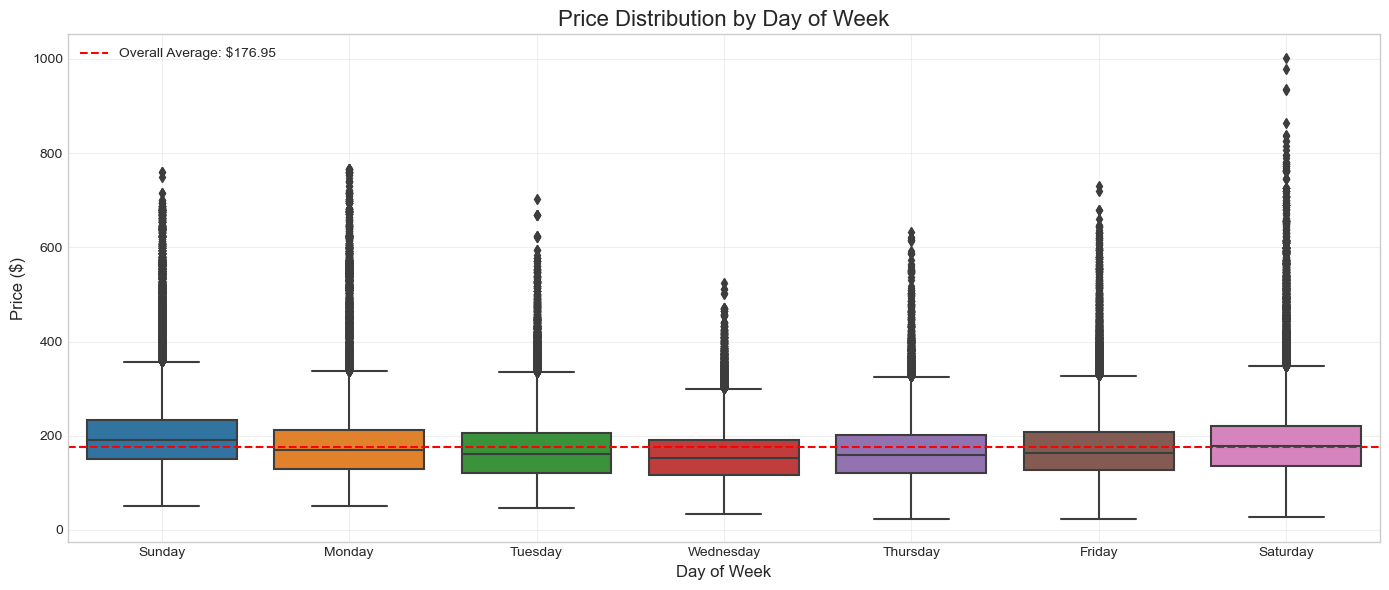

In [82]:
week_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
    
fig = plt.figure(figsize=(14, 6))

sns.boxplot(x='day_of_week', y='price', data=data, order=week_order)
plt.title('Price Distribution by Day of Week', fontsize=16)
plt.xlabel('Day of Week', fontsize=12)
plt.ylabel('Price ($)', fontsize=12)
plt.grid(True, alpha=0.3)

# Add average line
plt.axhline(y=data['price'].mean(), color='r', linestyle='--', 
            label=f'Overall Average: ${data["price"].mean():.2f}')
plt.legend()

plt.tight_layout()

In [83]:
from statsmodels.distributions.empirical_distribution import ECDF

def plot_detailed_distribution(df):
    """
    Creates a detailed price distribution analysis with histogram, KDE, and ECDF plots.
    
    Parameters:
    df (pandas.DataFrame): DataFrame containing flight data with a 'price' column
    
    Returns:
    matplotlib.figure.Figure: The figure containing the visualizations
    """
    # Create a subplot layout
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle('Detailed Price Distribution Analysis', fontsize=16)

    # Left plot: Histogram with KDE
    sns.histplot(df['price'].dropna(), bins=50, kde=True, ax=ax1, color='#4472C4', 
                 alpha=0.7, edgecolor='black', line_kws={'linewidth': 2})
    ax1.set_title('Price Distribution with Density Curve', fontsize=14)
    ax1.set_xlabel('Price ($)', fontsize=12)
    ax1.set_ylabel('Frequency', fontsize=12)

    # Add reference lines for percentiles
    percentiles = [0.1, 0.25, 0.5, 0.75, 0.9]
    colors = ['#FF9999', '#FFCC99', '#99FF99', '#FFCC99', '#FF9999']
    labels = ['10th', '25th', '50th', '75th', '90th']

    for i, p in enumerate(percentiles):
        value = df['price'].quantile(p)
        ax1.axvline(value, color=colors[i], linestyle='--', alpha=0.7, 
                   label=f'{labels[i]}: ${value:.2f}')

    ax1.legend(fontsize=9, title='Percentiles')

    # Right plot: ECDF (Empirical Cumulative Distribution Function)
    ecdf = ECDF(df['price'].dropna())
    ax2.plot(ecdf.x, ecdf.y * 100, linewidth=2, color='#4472C4')
    ax2.set_title('Cumulative Price Distribution', fontsize=14)
    ax2.set_xlabel('Price ($)', fontsize=12)
    ax2.set_ylabel('Cumulative Percentage (%)', fontsize=12)
    ax2.grid(True, alpha=0.3)

    # Add reference lines for key price points
    for i, p in enumerate(percentiles):
        value = df['price'].quantile(p)
        y_val = p * 100
        ax2.axhline(y=y_val, color=colors[i], linestyle='--', alpha=0.3)
        ax2.axvline(x=value, color=colors[i], linestyle='--', alpha=0.3)
        ax2.annotate(f'${value:.2f} ({y_val}%)', xy=(value, y_val), 
                    xytext=(10, 0), textcoords='offset points', fontsize=9)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    
    return fig

    """
    Creates a visualization of price distribution by day of week.
    
    Parameters:
    df (pandas.DataFrame): DataFrame containing flight data with 'price' and 'departure_date' columns
    
    Returns:
    matplotlib.figure.Figure or None: The figure containing the visualization or None if required data is missing
    """
    if 'departure_date' not in df.columns:
        print("Day of week analysis not possible: 'departure_date' column is missing")
        return None
        
    # Create a copy to avoid modifying the original DataFrame
    df_copy = df.copy()
    
    # Convert to datetime if needed
    if not pd.api.types.is_datetime64_any_dtype(df_copy['departure_date']):
        df_copy['departure_date'] = pd.to_datetime(df_copy['departure_date'])
    
    # Extract day of week
    df_copy['day_of_week'] = df_copy['departure_date'].dt.day_name()
    
    # Define week order
    week_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    
    # Create figure
    fig = plt.figure(figsize=(14, 6))
    
    # Plot
    sns.boxplot(x='day_of_week', y='price', data=df_copy, order=week_order)
    plt.title('Price Distribution by Day of Week', fontsize=16)
    plt.xlabel('Day of Week', fontsize=12)
    plt.ylabel('Price ($)', fontsize=12)
    plt.grid(True, alpha=0.3)
    
    # Add average line
    plt.axhline(y=df_copy['price'].mean(), color='r', linestyle='--', 
                label=f'Overall Average: ${df_copy["price"].mean():.2f}')
    plt.legend()
    
    plt.tight_layout()
    
    return fig

In [84]:
fig2 = plot_detailed_distribution(df)
plt.show()

NameError: name 'df' is not defined

In [ ]:
# Add this new function to analyze more specific aspects of your dataset

def plot_advanced_flight_analysis(df):
    """
    Creates visualizations for advanced flight price analysis based on airports,
    time of day, airlines, and connection types.
    
    Parameters:
    df (pandas.DataFrame): DataFrame containing detailed flight data
    
    Returns:
    matplotlib.figure.Figure: The figure containing the visualizations
    """
    # Create a 2x2 grid for additional analyses
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Advanced Flight Price Analysis', fontsize=20, y=0.98)
    
    # 1. Airport pair analysis (top-left)
    if all(col in df.columns for col in ['departure_airport', 'landing_airport']):
        # Create airport pairs
        df['airport_pair'] = df['departure_airport'] + ' → ' + df['landing_airport']
        
        # Get top 6 most common airport pairs
        top_pairs = df['airport_pair'].value_counts().nlargest(6).index.tolist()
        airport_pair_df = df[df['airport_pair'].isin(top_pairs)]
        
        # Create violin plot to show distribution
        sns.violinplot(x='airport_pair', y='price', data=airport_pair_df, ax=axes[0, 0], 
                      palette='coolwarm', cut=0, inner='quartile')
        axes[0, 0].set_title('Price Distribution by Airport Pair', fontsize=14)
        axes[0, 0].set_xlabel('Airport Pair', fontsize=12)
        axes[0, 0].set_ylabel('Price (€)', fontsize=12)
        axes[0, 0].tick_params(axis='x', rotation=45)
        
        # Add median prices
        medians = airport_pair_df.groupby('airport_pair')['price'].median()
        for i, pair in enumerate(axes[0, 0].get_xticklabels()):
            if pair.get_text() in medians.index:
                axes[0, 0].text(i, medians[pair.get_text()], f'€{medians[pair.get_text()]:.0f}', 
                              ha='center', va='bottom', fontsize=9, color='black')
    else:
        axes[0, 0].text(0.5, 0.5, 'Airport pair data not available', 
                      ha='center', va='center', fontsize=12)
        
    # 2. Time of day analysis (top-right)
    if 'departure_hour' in df.columns:
        # Create time categories
        df['time_category'] = pd.cut(
            df['departure_hour'], 
            bins=[0, 6, 12, 18, 24],
            labels=['Night (0-6)', 'Morning (6-12)', 'Afternoon (12-18)', 'Evening (18-24)']
        )
        
        # Create box plot
        sns.boxplot(x='time_category', y='price', data=df, ax=axes[0, 1], palette='viridis')
        axes[0, 1].set_title('Price by Departure Time', fontsize=14)
        axes[0, 1].set_xlabel('Time of Day', fontsize=12)
        axes[0, 1].set_ylabel('Price (€)', fontsize=12)
        
        # Add count and mean annotations
        for i, category in enumerate(df['time_category'].cat.categories):
            count = df[df['time_category'] == category].shape[0]
            mean = df[df['time_category'] == category]['price'].mean()
            axes[0, 1].annotate(f'n={count}\nμ=€{mean:.1f}', 
                              xy=(i, df['price'].min()), 
                              ha='center', va='bottom', fontsize=9)
    else:
        axes[0, 1].text(0.5, 0.5, 'Departure time data not available', 
                      ha='center', va='center', fontsize=12)
        
    # 3. Airline comparison (bottom-left)
    if 'return_company' in df.columns:
        # Get top 5 airlines by frequency
        top_airlines = df['return_company'].value_counts().nlargest(5).index.tolist()
        airline_df = df[df['return_company'].isin(top_airlines)]
        
        # Create violin plot
        sns.violinplot(x='return_company', y='price', data=airline_df, ax=axes[1, 0], 
                      palette='Set3', cut=0, inner='quartile')
        axes[1, 0].set_title('Price Distribution by Airline', fontsize=14)
        axes[1, 0].set_xlabel('Airline', fontsize=12)
        axes[1, 0].set_ylabel('Price (€)', fontsize=12)
        
        # Add statistics
        for i, airline in enumerate(top_airlines):
            airline_data = airline_df[airline_df['return_company'] == airline]
            if len(airline_data) > 0:
                med = airline_data['price'].median()
                axes[1, 0].text(i, med, f'€{med:.0f}', ha='center', va='bottom', fontsize=9)
    else:
        axes[1, 0].text(0.5, 0.5, 'Airline data not available', 
                      ha='center', va='center', fontsize=12)
        
    # 4. Direct vs Layover comparison (bottom-right)
    if 'layover' in df.columns:
        # Create a DataFrame for plotting
        df['connection_type'] = df['layover'].map({True: 'With Layover', False: 'Direct'})
        
        # Split by connection type
        sns.boxplot(x='connection_type', y='price', data=df, ax=axes[1, 1], palette='Set2')
        axes[1, 1].set_title('Direct vs. Connecting Flights Price Comparison', fontsize=14)
        axes[1, 1].set_xlabel('Flight Type', fontsize=12)
        axes[1, 1].set_ylabel('Price (€)', fontsize=12)
        
        # Add statistics
        for i, conn_type in enumerate(['Direct', 'With Layover']):
            if conn_type == 'Direct':
                data = df[df['layover'] == False]
            else:
                data = df[df['layover'] == True]
            
            if len(data) > 0:
                count = len(data)
                mean = data['price'].mean()
                axes[1, 1].annotate(f'n={count}\nμ=€{mean:.1f}', 
                                  xy=(i, df['price'].min()), 
                                  ha='center', va='bottom', fontsize=9)
                
        # If layover_time is available, add a secondary plot
        if 'layover_time' in df.columns and df['layover'].any():
            # Create a twin axis
            ax2 = axes[1, 1].twinx()
            
            # Only use flights with layovers for the scatter plot
            layover_df = df[df['layover'] == True].copy()
            
            # Convert layover time to hours if it's in minutes
            if layover_df['layover_time'].max() > 24:  # assuming it's in minutes if > 24
                layover_df['layover_hours'] = layover_df['layover_time'] / 60
            else:
                layover_df['layover_hours'] = layover_df['layover_time']
                
            # Scatter plot of layover time vs price
            if len(layover_df) > 0:
                ax2.scatter(
                    [1] * len(layover_df),  # Position at the "With Layover" category
                    layover_df['price'],
                    c=layover_df['layover_hours'],
                    cmap='coolwarm',
                    alpha=0.6,
                    s=50,
                    edgecolor='black',
                    linewidth=0.5
                )
                ax2.set_ylabel('Price (€) colored by layover duration', fontsize=10)
    else:
        axes[1, 1].text(0.5, 0.5, 'Layover data not available', 
                      ha='center', va='center', fontsize=12)
    
    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    
    return fig

/var/folders/f0/l96rg_wj4qvg_lzh89qycdgc0000gn/T/ipykernel_36374/3991931317.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='airport_pair', y='price', data=airport_pair_df, ax=axes[0, 0],
/var/folders/f0/l96rg_wj4qvg_lzh89qycdgc0000gn/T/ipykernel_36374/3991931317.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='time_category', y='price', data=df, ax=axes[0, 1], palette='viridis')
/var/folders/f0/l96rg_wj4qvg_lzh89qycdgc0000gn/T/ipykernel_36374/3991931317.py:78: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='to_dest_comp

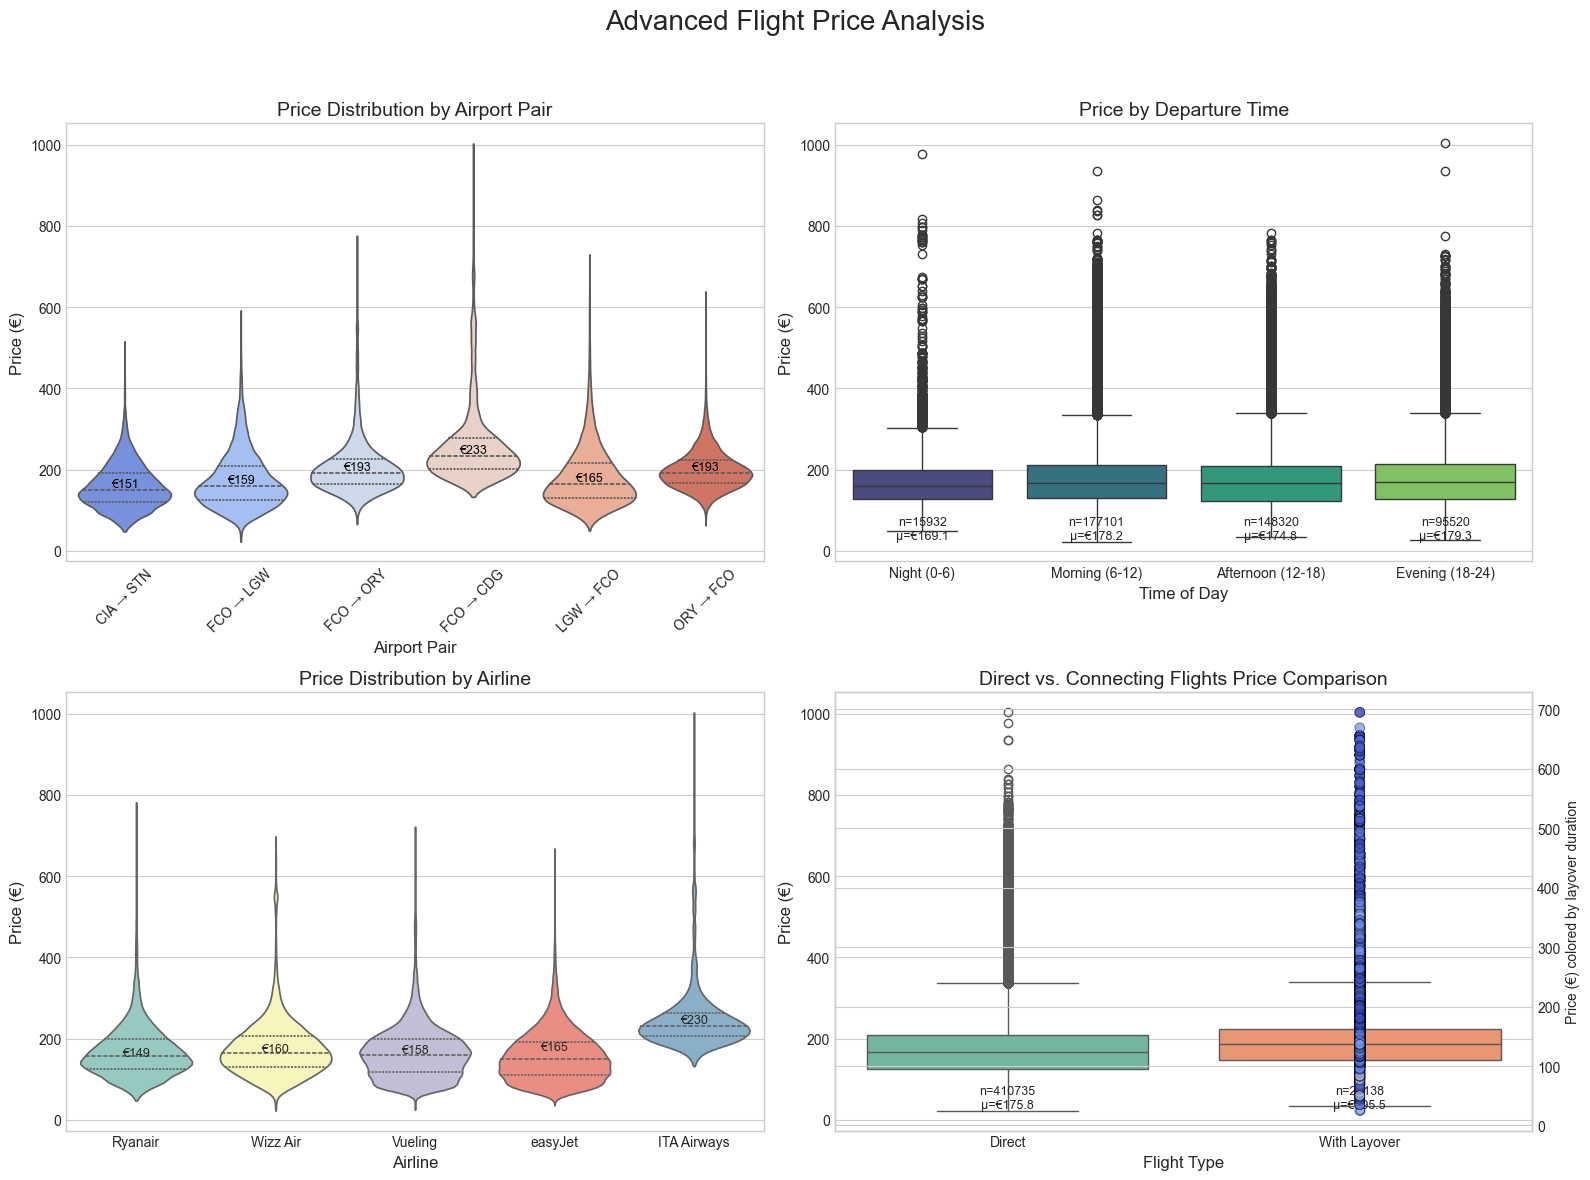

In [ ]:
fig4 = plot_advanced_flight_analysis(data)
plt.show()